# Train and Eval
Train and evaluate model
- <a href='#1'>1. lightgbm</a> 
- <a href='#2'>2. task2</a> 
- <a href='#3'>3. ensemble</a>

In [3]:
import sys
import os 
import gc
from time import time 
from datetime import timedelta, datetime

import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import lightgbm as lgb
from sklearn import metrics
import chart_studio.plotly as py
import cufflinks as cf

sys.path.append('../')
import conf
from utils import (
    check_columns, 
    check_nan_value, 
    correct_colum_type, 
    decrypt_model, 
    plot_dist_of_cols,
)
from mlpipeline.train_eval import train_pipeline_lightgbm, pipeline_inference

In [4]:
# global settings
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns',1000)
pd.set_option('display.width',100)
sns.set(rc={'figure.figsize':(20,10)})

In [5]:
# global variables
DEFAULT_MISSING_FLOAT = 0


In [6]:
# functions
def __dummy():
    pass

### <a id='1'> 1.lightgbm</a>

In [7]:
! du -sh ../data/*

2.5G	../data/data_2017_tag_flag.h5
1.2G	../data/data_2018_1_2_3_tag_flag.h5
1.8G	../data/data_2018_4_5_6_tag_flag.h5
36K	../data/disk_sample_fault_tag.csv
1.2G	../data/disk_sample_smart_log_201707.csv
228M	../data/disk_sample_smart_log_201707_norm.csv
233M	../data/disk_sample_smart_log_201707_raw.csv
2.2G	../data/disk_sample_smart_log_201708.csv
446M	../data/disk_sample_smart_log_201708_norm.csv
460M	../data/disk_sample_smart_log_201708_raw.csv
2.2G	../data/disk_sample_smart_log_201709.csv
450M	../data/disk_sample_smart_log_201709_norm.csv
468M	../data/disk_sample_smart_log_201709_raw.csv
2.5G	../data/disk_sample_smart_log_201710.csv
507M	../data/disk_sample_smart_log_201710_norm.csv
530M	../data/disk_sample_smart_log_201710_raw.csv
2.6G	../data/disk_sample_smart_log_201711.csv
523M	../data/disk_sample_smart_log_201711_norm.csv
551M	../data/disk_sample_smart_log_201711_raw.csv
2.9G	../data/disk_sample_smart_log_201712.csv
590M	../data/disk_sample_smart_log_201712_norm.csv
625M	../data/

In [8]:
fe_df = pd.read_hdf(os.path.join(conf.DATA_DIR, 'data_2018_4_5_6_tag_flag.h5'))

In [9]:
fe_df.head()

,serial_number,manufacturer,model,dt,smart_1_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,smart_7_normalized,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_184_normalized,smart_187_normalized,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_191_normalized,smart_192_normalized,smart_193_normalized,smart_194_normalized,smart_195_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized,smart_240_normalized,smart_241_normalized,smart_242_normalized,tag,flag
0,disk_115552,A,1,2018-04-01,80.0,96.0,100.0,100.0,94.0,60.0,100.0,100.0,100.0,100.0,100.0,99.0,71.0,100.0,100.0,100.0,29.0,47.0,100.0,100.0,200.0,NaN,NaN,NaN,0,False
1,disk_115560,A,1,2018-04-01,69.0,96.0,100.0,100.0,93.0,61.0,100.0,100.0,100.0,100.0,100.0,100.0,69.0,100.0,100.0,100.0,31.0,9.0,100.0,100.0,200.0,NaN,NaN,NaN,0,False
2,disk_115561,A,1,2018-04-01,77.0,96.0,100.0,100.0,93.0,61.0,100.0,100.0,100.0,100.0,100.0,98.0,69.0,100.0,100.0,100.0,31.0,64.0,100.0,100.0,200.0,NaN,NaN,NaN,0,False
3,disk_115563,A,1,2018-04-01,78.0,96.0,100.0,100.0,93.0,66.0,100.0,100.0,100.0,100.0,100.0,100.0,72.0,100.0,100.0,100.0,28.0,45.0,100.0,100.0,200.0,NaN,NaN,NaN,0,False
4,disk_115563,A,1,2018-04-01,82.0,96.0,100.0,100.0,93.0,67.0,100.0,100.0,100.0,100.0,100.0,100.0,73.0,100.0,100.0,100.0,27.0,47.0,100.0,100.0,200.0,NaN,NaN,NaN,0,False


In [12]:
# get model 1 data
mask = fe_df['model']==1
mod_one_fe_df = fe_df[mask]

In [13]:
drop_na_cols = check_nan_value(mod_one_fe_df)

serial_number - 0.0 
manufacturer - 0.0 
model - 0.0 
dt - 0.0 
smart_1_normalized - 0.0 
smart_3_normalized - 0.0 
smart_4_normalized - 0.0 
smart_5_normalized - 0.0 
smart_7_normalized - 0.0 
smart_9_normalized - 0.0 
smart_10_normalized - 0.0 
smart_12_normalized - 0.0 
smart_184_normalized - 0.0 
smart_187_normalized - 0.0 
smart_188_normalized - 0.0 
smart_189_normalized - 0.0 
smart_190_normalized - 0.0 
smart_191_normalized - 0.0 
smart_192_normalized - 0.0 
smart_193_normalized - 0.0 
smart_194_normalized - 0.0 
smart_195_normalized - 0.0 
smart_197_normalized - 0.0 
smart_198_normalized - 0.0 
smart_199_normalized - 0.0 
smart_240_normalized - 99.46 
smart_241_normalized - 99.46 
smart_242_normalized - 99.46 
tag - 0.0 
flag - 0.0 


In [14]:
mod_one_fe_df.drop(columns=drop_na_cols, inplace=True)

In [15]:
mod_one_fe_df.head()

,serial_number,manufacturer,model,dt,smart_1_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,smart_7_normalized,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_184_normalized,smart_187_normalized,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_191_normalized,smart_192_normalized,smart_193_normalized,smart_194_normalized,smart_195_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized,tag,flag
0,disk_115552,A,1,2018-04-01,80.0,96.0,100.0,100.0,94.0,60.0,100.0,100.0,100.0,100.0,100.0,99.0,71.0,100.0,100.0,100.0,29.0,47.0,100.0,100.0,200.0,0,False
1,disk_115560,A,1,2018-04-01,69.0,96.0,100.0,100.0,93.0,61.0,100.0,100.0,100.0,100.0,100.0,100.0,69.0,100.0,100.0,100.0,31.0,9.0,100.0,100.0,200.0,0,False
2,disk_115561,A,1,2018-04-01,77.0,96.0,100.0,100.0,93.0,61.0,100.0,100.0,100.0,100.0,100.0,98.0,69.0,100.0,100.0,100.0,31.0,64.0,100.0,100.0,200.0,0,False
3,disk_115563,A,1,2018-04-01,78.0,96.0,100.0,100.0,93.0,66.0,100.0,100.0,100.0,100.0,100.0,100.0,72.0,100.0,100.0,100.0,28.0,45.0,100.0,100.0,200.0,0,False
4,disk_115563,A,1,2018-04-01,82.0,96.0,100.0,100.0,93.0,67.0,100.0,100.0,100.0,100.0,100.0,100.0,73.0,100.0,100.0,100.0,27.0,47.0,100.0,100.0,200.0,0,False


In [16]:
# correct col type
correct_colum_type(mod_one_fe_df)

serial_number                   object
manufacturer                    object
model                             int8
dt                      datetime64[ns]
smart_1_normalized             float32
smart_3_normalized             float32
smart_4_normalized             float32
smart_5_normalized             float32
smart_7_normalized             float32
smart_9_normalized             float32
smart_10_normalized            float32
smart_12_normalized            float32
smart_184_normalized           float32
smart_187_normalized           float32
smart_188_normalized           float32
smart_189_normalized           float32
smart_190_normalized           float32
smart_191_normalized           float32
smart_192_normalized           float32
smart_193_normalized           float32
smart_194_normalized           float32
smart_195_normalized           float32
smart_197_normalized           float32
smart_198_normalized           float32
smart_199_normalized           float32
tag                      

In [17]:
mod_one_fe_df.loc[mod_one_fe_df.tag!=0,'tag']=1

In [19]:
mod_one_fe_df.tag.value_counts()

0    8612102
1       8702
Name: tag, dtype: int64

In [20]:
mod_one_fe_df.memory_usage().sum()/1024**2

978.3512840270996

In [21]:
del fe_df
gc.collect()

0

In [22]:
mod_one_fe_df.head()

,serial_number,manufacturer,model,dt,smart_1_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,smart_7_normalized,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_184_normalized,smart_187_normalized,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_191_normalized,smart_192_normalized,smart_193_normalized,smart_194_normalized,smart_195_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized,tag,flag
0,disk_115552,A,1,2018-04-01,80.0,96.0,100.0,100.0,94.0,60.0,100.0,100.0,100.0,100.0,100.0,99.0,71.0,100.0,100.0,100.0,29.0,47.0,100.0,100.0,200.0,0,False
1,disk_115560,A,1,2018-04-01,69.0,96.0,100.0,100.0,93.0,61.0,100.0,100.0,100.0,100.0,100.0,100.0,69.0,100.0,100.0,100.0,31.0,9.0,100.0,100.0,200.0,0,False
2,disk_115561,A,1,2018-04-01,77.0,96.0,100.0,100.0,93.0,61.0,100.0,100.0,100.0,100.0,100.0,98.0,69.0,100.0,100.0,100.0,31.0,64.0,100.0,100.0,200.0,0,False
3,disk_115563,A,1,2018-04-01,78.0,96.0,100.0,100.0,93.0,66.0,100.0,100.0,100.0,100.0,100.0,100.0,72.0,100.0,100.0,100.0,28.0,45.0,100.0,100.0,200.0,0,False
4,disk_115563,A,1,2018-04-01,82.0,96.0,100.0,100.0,93.0,67.0,100.0,100.0,100.0,100.0,100.0,100.0,73.0,100.0,100.0,100.0,27.0,47.0,100.0,100.0,200.0,0,False


In [23]:
params = {"objective": "binary", 
          "learning_rate": 0.01,
          'scale_pos_weight':1000,               
          'metric':['binary_log_loss','auc'], 
          'subsample':0.7, 
          'max_bin':255, 
          'n_thread':3}

In [24]:
model, eval_df = train_pipeline_lightgbm(mod_one_fe_df, split_date='2018-06-01', params=params)

开始训练
[1]	valid_0's auc: 0.66372
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.666272
[3]	valid_0's auc: 0.665706
[4]	valid_0's auc: 0.665816
[5]	valid_0's auc: 0.665646
[6]	valid_0's auc: 0.661461
[7]	valid_0's auc: 0.664879
[8]	valid_0's auc: 0.665381
[9]	valid_0's auc: 0.666038
[10]	valid_0's auc: 0.666286
[11]	valid_0's auc: 0.666892
[12]	valid_0's auc: 0.666132
[13]	valid_0's auc: 0.666199
[14]	valid_0's auc: 0.667229
[15]	valid_0's auc: 0.667618
[16]	valid_0's auc: 0.669743
[17]	valid_0's auc: 0.66988
[18]	valid_0's auc: 0.670043
[19]	valid_0's auc: 0.670302
[20]	valid_0's auc: 0.670482
[21]	valid_0's auc: 0.670665
[22]	valid_0's auc: 0.670753
[23]	valid_0's auc: 0.670984
[24]	valid_0's auc: 0.670988
[25]	valid_0's auc: 0.671442
[26]	valid_0's auc: 0.671921
[27]	valid_0's auc: 0.673363
[28]	valid_0's auc: 0.672876
[29]	valid_0's auc: 0.673134
[30]	valid_0's auc: 0.67397
[31]	valid_0's auc: 0.674853
[32]	valid_0's auc: 0.675819
[33]	valid_0's auc

In [26]:
eval_df.head(100)

,tag,serial_number,manufacturer,model,dt,prediction
0,0,disk_58088,A,1,2018-06-01,0
1,0,disk_58088,A,1,2018-06-01,0
2,0,disk_58089,A,1,2018-06-01,0
3,0,disk_58094,A,1,2018-06-01,1
4,0,disk_58096,A,1,2018-06-01,0
5,0,disk_58098,A,1,2018-06-01,0
6,0,disk_58099,A,1,2018-06-01,0
7,0,disk_58099,A,1,2018-06-01,0
8,0,disk_5810,A,1,2018-06-01,0
9,0,disk_58104,A,1,2018-06-01,0


In [27]:
# clean test data
test_fe_df = pd.read_hdf(os.path.join(conf.DATA_DIR, 'test_fe_df.h5'))

In [28]:
drop_na_cols = check_nan_value(test_fe_df)

serial_number - 0.0 
manufacturer - 0.0 
model - 0.0 
dt - 0.0 
smart_1_normalized - 0.0 
smart_3_normalized - 0.0 
smart_4_normalized - 0.0 
smart_5_normalized - 0.0 
smart_7_normalized - 0.0 
smart_9_normalized - 0.0 
smart_10_normalized - 0.0 
smart_12_normalized - 0.0 
smart_184_normalized - 0.0 
smart_187_normalized - 0.0 
smart_188_normalized - 0.0 
smart_189_normalized - 0.0 
smart_190_normalized - 0.0 
smart_191_normalized - 0.0 
smart_192_normalized - 0.0 
smart_193_normalized - 0.0 
smart_194_normalized - 0.0 
smart_195_normalized - 0.0 
smart_197_normalized - 0.0 
smart_198_normalized - 0.0 
smart_199_normalized - 0.0 


In [29]:
test_fe_df.drop(columns=drop_na_cols, inplace=True)

In [30]:
correct_colum_type(test_fe_df)

serial_number                   object
manufacturer                    object
model                             int8
dt                      datetime64[ns]
smart_1_normalized             float32
smart_3_normalized             float32
smart_4_normalized             float32
smart_5_normalized             float32
smart_7_normalized             float32
smart_9_normalized             float32
smart_10_normalized            float32
smart_12_normalized            float32
smart_184_normalized           float32
smart_187_normalized           float32
smart_188_normalized           float32
smart_189_normalized           float32
smart_190_normalized           float32
smart_191_normalized           float32
smart_192_normalized           float32
smart_193_normalized           float32
smart_194_normalized           float32
smart_195_normalized           float32
smart_197_normalized           float32
smart_198_normalized           float32
smart_199_normalized           float32
dtype: object


In [31]:
test_fe_df.head()

,serial_number,manufacturer,model,dt,smart_1_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,smart_7_normalized,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_184_normalized,smart_187_normalized,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_191_normalized,smart_192_normalized,smart_193_normalized,smart_194_normalized,smart_195_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized
0,disk_119164,A,1,2018-08-01,73.0,97.0,100.0,100.0,93.0,57.0,100.0,100.0,100.0,100.0,100.0,100.0,69.0,100.0,100.0,100.0,31.0,62.0,100.0,100.0,200.0
1,disk_119437,A,1,2018-08-01,83.0,96.0,100.0,100.0,93.0,64.0,100.0,100.0,100.0,100.0,100.0,100.0,69.0,100.0,100.0,100.0,31.0,23.0,100.0,100.0,200.0
2,disk_119991,A,1,2018-08-01,75.0,95.0,100.0,100.0,96.0,59.0,100.0,100.0,100.0,100.0,100.0,85.0,68.0,100.0,100.0,100.0,32.0,60.0,100.0,100.0,200.0
3,disk_119991,A,1,2018-08-01,81.0,95.0,100.0,100.0,96.0,59.0,100.0,100.0,100.0,100.0,100.0,85.0,68.0,100.0,100.0,100.0,32.0,57.0,100.0,100.0,200.0
4,disk_120372,A,1,2018-08-01,83.0,96.0,100.0,100.0,93.0,58.0,100.0,100.0,100.0,100.0,100.0,100.0,69.0,100.0,100.0,100.0,31.0,23.0,100.0,100.0,200.0


In [32]:
test_fe_df.model.value_counts()

1    178096
Name: model, dtype: int64

In [28]:
test_fe_df.head()

,serial_number,manufacturer,model,dt,smart_1_normalized,smart_3_normalized,smart_4_normalized,smart_5_normalized,smart_7_normalized,smart_9_normalized,smart_10_normalized,smart_12_normalized,smart_184_normalized,smart_187_normalized,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_191_normalized,smart_192_normalized,smart_193_normalized,smart_194_normalized,smart_195_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized
0,disk_119164,A,1,2018-08-01,73.0,97.0,100.0,100.0,93.0,57.0,100.0,100.0,100.0,100.0,100.0,100.0,69.0,100.0,100.0,100.0,31.0,62.0,100.0,100.0,200.0
1,disk_119437,A,1,2018-08-01,83.0,96.0,100.0,100.0,93.0,64.0,100.0,100.0,100.0,100.0,100.0,100.0,69.0,100.0,100.0,100.0,31.0,23.0,100.0,100.0,200.0
2,disk_119991,A,1,2018-08-01,75.0,95.0,100.0,100.0,96.0,59.0,100.0,100.0,100.0,100.0,100.0,85.0,68.0,100.0,100.0,100.0,32.0,60.0,100.0,100.0,200.0
3,disk_119991,A,1,2018-08-01,81.0,95.0,100.0,100.0,96.0,59.0,100.0,100.0,100.0,100.0,100.0,85.0,68.0,100.0,100.0,100.0,32.0,57.0,100.0,100.0,200.0
4,disk_120372,A,1,2018-08-01,83.0,96.0,100.0,100.0,93.0,58.0,100.0,100.0,100.0,100.0,100.0,100.0,69.0,100.0,100.0,100.0,31.0,23.0,100.0,100.0,200.0


In [33]:
ret, output_df = pipeline_inference(test_fe_df)

submission_2020-02-23T00:13:07.101583.csv已保存至../submission/submission_2020-02-23T00:13:07.101583.csv


In [34]:
_, cate_cols, cont_cols, _ = check_columns(test_fe_df.dtypes.to_dict())

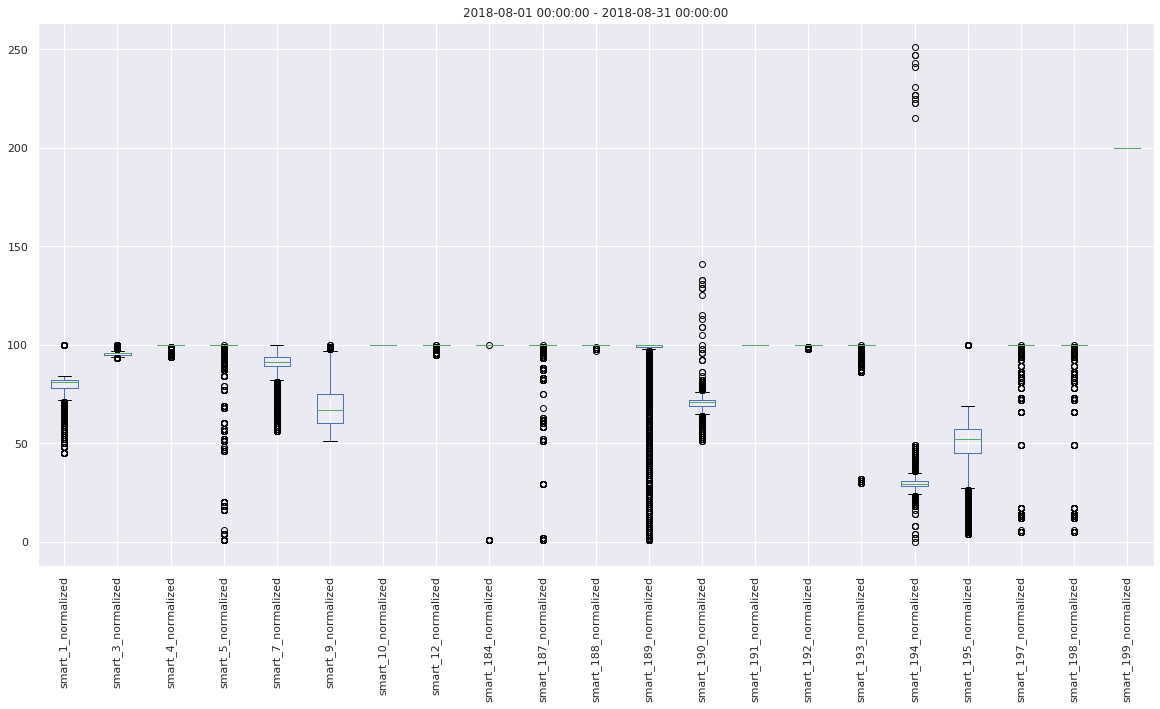

2018-08-01 00:00:00 - 2018-08-31 00:00:00_dist.png has been saved in ../figs/2018-08-01 00:00:00 - 2018-08-31 00:00:00_dist.png 


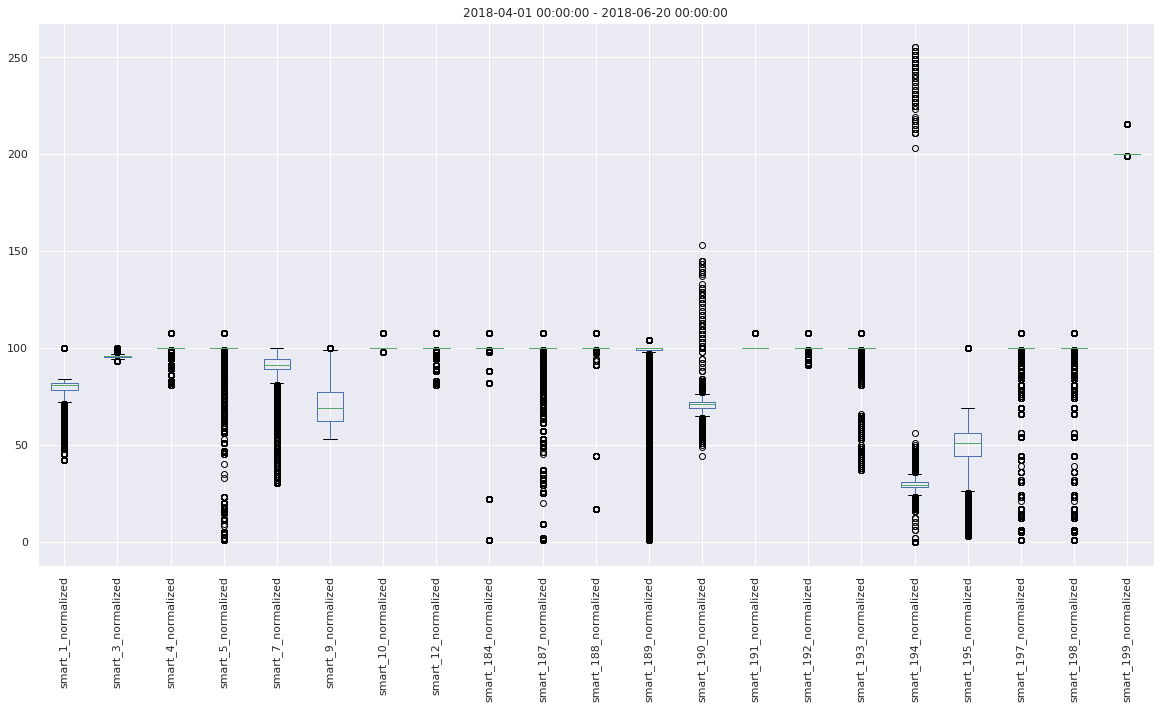

2018-04-01 00:00:00 - 2018-06-20 00:00:00_dist.png has been saved in ../figs/2018-04-01 00:00:00 - 2018-06-20 00:00:00_dist.png 


<Figure size 1440x720 with 0 Axes>

In [35]:
plot_dist_of_cols([test_fe_df, mod_one_fe_df,], cont_cols)

In [67]:
test_fe_df.to_hdf(os.path.join(conf.DATA_DIR, 'test_fe_df.h5'), key='test_fe_df')